# 転移学習とは


転移学習（Transfer-Learning）とはあるタスクで学習を行なったモデルを、別のタスクで再利用する手法全般のこと


・例えばCNNで画像認識などを一からモデル構築すると、大量のサンプル画像を集めなければいけないですし、さらに学習にも多くの時間がかかる

・転移学習では、すでに学習済みのモデルを使って、より少ない画像、より短時間で学習モデルを構築することを目指す

## 【問題1】コードレビュー
転移学習を使用してセグメンテーションの精度を改善したコードを提示するので、レビューを行ってください。


《視点例》


・前回使用した実装とはどのように違うのか

・転移学習をどのように行っているか

前回に引き続きTGS Salt Identification Challengのデータセットの学習・推定を行い
ます。


[TGS Salt Identification Challenge | Kaggle](https://www.kaggle.com/c/tgs-salt-identification-challenge)

## Model architecture tuning & score optimization


Some ideas and code taken from ealier [kernel](https://www.kaggle.com/wrosinski/clean-workflow-in-keras) and last prepared notebook.

Having dealt with data processing & engineering of channel features, next step of modeling is preparation and tuning of model architecture. Earlier notebooks provided a way to create images with three channels, which will facilitate usage of pretrained models.

For segmentation tasks, a pretrained model can be used as encoder part of the final architecture. 
In order to use pretrained models, we will have to extract features from a few intermediate layers, which will then serve as a basis for layers coming afterwards and for skip connections between encoder and decoder part.

ResNet50 is a good starting point, because it consists of 4 blocks, where each one of them can serve as feature extractor with first layer serving as the 5th extractor to achieve consistency with standard UNet architecture.

##モデルアーキテクチャの調整とスコアの最適化


ealier [kernel](https://www.kaggle.com/wrosinski/clean-workflow-in-keras)
と最後に準備されたノートブックから取得したいくつかのアイデアとコード。

チャネル機能のデータ処理とエンジニアリングを扱った後、モデリングの次のステップは、モデルアーキテクチャの準備と調整です。 以前のノートブックは、事前にトレーニングされたモデルの使用を容易にする3つのチャネルで画像を作成する方法を提供していました。

セグメンテーションタスクの場合、事前にトレーニングされたモデルを最終アーキテクチャのエンコーダ部分として使用できます。
事前トレーニング済みモデルを使用するには、いくつかの中間レイヤーから特徴を抽出する必要があります。これは、その後に来るレイヤーの基礎として、またエンコーダーとデコーダー部分の間のスキップ接続の基礎として機能します。

ResNet50は4つのブロックで構成されているため、出発点として適しています。各ブロックは特徴抽出器として機能し、最初のレイヤーが5番目の抽出器として機能して、標準のUNetアーキテクチャとの整合性を実現します。

In [3]:
import tensorflow as tf
tf.test.gpu_device_name()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

'/device:GPU:0'

In [ ]:
!pip install keras==2.3.1

In [2]:
!pip uninstall -y tensorflow
!pip install tensorflow-gpu==1.14.0

Uninstalling tensorflow-2.3.0:
  Successfully uninstalled tensorflow-2.3.0
     |████████████████████████████████| 377.0MB 44kB/s 
     |████████████████████████████████| 491kB 2.7MB/s 
     |████████████████████████████████| 3.2MB 8.4MB/s 
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0


In [ ]:
!pip install tensorflow==1.14

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/'My Drive'/train.zip -d train_salt

In [ ]:
!unzip /content/drive/'My Drive'/test.zip -d test_salt

In [27]:
import gc
import glob
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split, StratifiedKFold
from tqdm import tqdm

from keras import optimizers
from keras.callbacks import *
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import *
from keras.models import Model, load_model, save_model
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.applications.vgg16 import VGG16

%matplotlib inline

In [9]:
plt.rcParams['figure.figsize'] = (12, 9)
# plt.style.use('ggplot')

In [10]:
def compute_coverage(df, masks):
    
    df = df.copy()
    
    # クラスを11に分類
    def cov_to_class(val):
        for i in range(0, 11):
            if val * 10 <= i:
                return i

    # 0 or 1 の確率%を求めている
    df['coverage'] = np.mean(masks, axis=(1, 2))
    # 塩の%に応じて11クラスに分類
    df['coverage_class'] = df.coverage.map(
        cov_to_class)

    return df


def create_depth_abs_channels(image_tensor):
    image_tensor = image_tensor.astype(np.float32)
    h, w, c = image_tensor.shape
    for row, const in enumerate(np.linspace(0, 1, h)):
        image_tensor[row, :, 1] = const
    image_tensor[:, :, 2] = (
        image_tensor[:, :, 0] * image_tensor[:, :, 1])

    x_dx = np.diff(image_tensor[:, :, 0], axis=0)
    x_dy = np.diff(image_tensor[:, :, 0], axis=1)
    x_dx = cv2.copyMakeBorder(x_dx, 1, 0, 0, 0, cv2.BORDER_CONSTANT, 0)
    x_dy = cv2.copyMakeBorder(x_dy, 0, 0, 1, 0, cv2.BORDER_CONSTANT, 0)
    image_tensor[:, :, 1] = np.abs(x_dx + x_dy)

    return image_tensor

### Data loading & depth merge:

In [11]:
train = pd.read_csv('/content/drive/My Drive/train.csv')
test = pd.read_csv('/content/drive/My Drive/sample_submission.csv')
depth = pd.read_csv('/content/drive/My Drive/depths.csv')


train_src = '../input/train/'

print('train:\n{}'.format(train.head()))
print('\ntest:\n{}'.format(test.head()))


train = train.merge(depth, how='left', on='id')
test = test.merge(depth, how='left', on='id')

print('\n{}'.format(train.head()))

train:
           id                                           rle_mask
0  575d24d81d                                                NaN
1  a266a2a9df                                          5051 5151
2  75efad62c1  9 93 109 94 210 94 310 95 411 95 511 96 612 96...
3  34e51dba6a  48 54 149 54 251 53 353 52 455 51 557 50 659 4...
4  4875705fb0  1111 1 1212 1 1313 1 1414 1 1514 2 1615 2 1716...

test:
           id rle_mask
0  155410d6fa      1 1
1  78b32781d1      1 1
2  63db2a476a      1 1
3  17bfcdb967      1 1
4  7ea0fd3c88      1 1

           id                                           rle_mask    z
0  575d24d81d                                                NaN  843
1  a266a2a9df                                          5051 5151  794
2  75efad62c1  9 93 109 94 210 94 310 95 411 95 511 96 612 96...  468
3  34e51dba6a  48 54 149 54 251 53 353 52 455 51 557 50 659 4...  727
4  4875705fb0  1111 1 1212 1 1313 1 1414 1 1514 2 1615 2 1716...  797


### Load images and masks, examine random sample:

###画像とマスクを読み込み、ランダムサンプルを調べます。

In [12]:
# 画像呼んで正規化
X_train = np.asarray(
    [cv2.imread('/content/train_salt/images/{}.png'.format(x), 0) for x in train.id.tolist()], 
    dtype=np.uint8) / 255.
y_train = np.asarray(
    [cv2.imread('/content/train_salt/masks/{}.png'.format(x), 0) for x in train.id.tolist()],
    dtype=np.uint8) / 255.

print(X_train.shape, y_train.shape)

(4000, 101, 101) (4000, 101, 101)


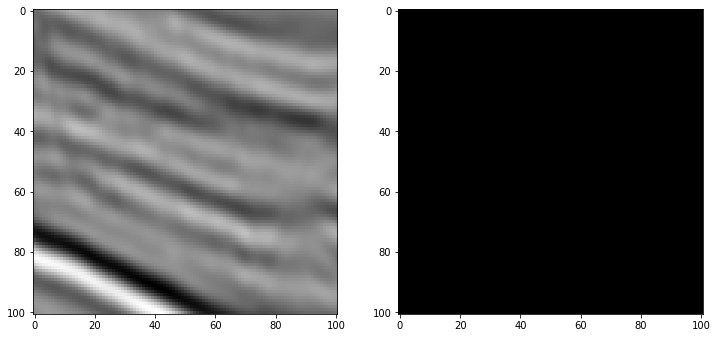

In [13]:
# ランダムに選んで表示
random_index = np.random.randint(0, X_train.shape[0])

fig, ax = plt.subplots(1, 2)

ax[0].imshow(X_train[random_index], cmap='gray')
ax[1].imshow(y_train[random_index], cmap='gray')

### Compute salt coverage (this will serve as a basis for stratified split):

###ソルトカバレッジを計算します（これは層化分割の基礎として機能します）：

In [14]:
# 塩の確率求めて、クラス(11個)分けし、trainのdfに追加
train = compute_coverage(train, y_train)

### Prepare data for training:

In [15]:
kfold = StratifiedKFold(n_splits=5, random_state=1337)

# チャンネル数追加
# 次元を足して3回繰り返す
X_train_ch = np.repeat(np.expand_dims(X_train, axis=-1), 3, -1)
X_train_ch = np.asarray(list(map(lambda x: create_depth_abs_channels(x), X_train_ch)))

# ResNet50のデフォルトサイズに変更
X_resized = np.asarray(list(map(lambda x: cv2.resize(x, (224, 224)), X_train_ch)))
y_resized = np.asarray(list(map(lambda x: cv2.resize(x, (224, 224)), y_train)))


for train_index, valid_index in kfold.split(train.id.values, train.coverage_class.values):
    
    X_tr, X_val = X_resized[train_index], X_resized[valid_index]
    y_tr, y_val = y_resized[train_index], y_resized[valid_index]
    
    break
    
# 次元増やす
y_tr = np.expand_dims(y_tr, axis=-1)
y_val = np.expand_dims(y_val, axis=-1)

print(X_tr.shape, y_tr.shape)
print(X_val.shape, y_val.shape)


del X_train_ch, y_resized
del X_resized
gc.collect()

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


(3200, 224, 224, 3) (3200, 224, 224, 1)
(800, 224, 224, 3) (800, 224, 224, 1)


82

### Loss functions & metric:

In [16]:
from keras.losses import binary_crossentropy


# Dice & combined
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score


def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score


def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)


def bce_logdice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))



# Lovash loss: https://github.com/bermanmaxim/LovaszSoftmax
def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    gts = tf.reduce_sum(gt_sorted)
    intersection = gts - tf.cumsum(gt_sorted)
    union = gts + tf.cumsum(1. - gt_sorted)
    jaccard = 1. - intersection / union
    jaccard = tf.concat((jaccard[0:1], jaccard[1:] - jaccard[:-1]), 0)
    return jaccard


# --------------------------- BINARY LOSSES ---------------------------

def lovasz_hinge(logits, labels, per_image=True, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    if per_image:
        def treat_image(log_lab):
            log, lab = log_lab
            log, lab = tf.expand_dims(log, 0), tf.expand_dims(lab, 0)
            log, lab = flatten_binary_scores(log, lab, ignore)
            return lovasz_hinge_flat(log, lab)
        losses = tf.map_fn(treat_image, (logits, labels), dtype=tf.float32)
        loss = tf.reduce_mean(losses)
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
    return loss


def lovasz_hinge_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """

    def compute_loss():
        labelsf = tf.cast(labels, logits.dtype)
        signs = 2. * labelsf - 1.
        errors = 1. - logits * tf.stop_gradient(signs)
        errors_sorted, perm = tf.nn.top_k(errors, k=tf.shape(errors)[0], name="descending_sort")
        gt_sorted = tf.gather(labelsf, perm)
        grad = lovasz_grad(gt_sorted)
        loss = tf.tensordot(tf.nn.relu(errors_sorted), tf.stop_gradient(grad), 1, name="loss_non_void")
        return loss

    # deal with the void prediction case (only void pixels)
    loss = tf.cond(tf.equal(tf.shape(logits)[0], 0),
                   lambda: tf.reduce_sum(logits) * 0.,
                   compute_loss,
                   strict=True,
                   name="loss"
                   )
    return loss


def flatten_binary_scores(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = tf.reshape(scores, (-1,))
    labels = tf.reshape(labels, (-1,))
    if ignore is None:
        return scores, labels
    valid = tf.not_equal(labels, ignore)
    vscores = tf.boolean_mask(scores, valid, name='valid_scores')
    vlabels = tf.boolean_mask(labels, valid, name='valid_labels')
    return vscores, vlabels


def lovasz_loss(y_true, y_pred):
    y_true, y_pred = K.cast(K.squeeze(y_true, -1), 'int32'), K.cast(K.squeeze(y_pred, -1), 'float32')
    #logits = K.log(y_pred / (1. - y_pred))
    logits = y_pred #Jiaxin
    loss = lovasz_hinge(logits, y_true, per_image = True, ignore = None)
    return loss


# IoU metric for observation during training
# https://www.kaggle.com/cpmpml/fast-iou-metric-in-numpy-and-tensorflow
def get_iou_vector(A, B):
    # Numpy version    
    batch_size = A.shape[0]
    metric = 0.0
    for batch in range(batch_size):
        t, p = A[batch], B[batch]
        true = np.sum(t)
        pred = np.sum(p)
        
        # deal with empty mask first
        if true == 0:
            metric += (pred == 0)
            continue
        
        # non empty mask case.  Union is never empty 
        # hence it is safe to divide by its number of pixels
        intersection = np.sum(t * p)
        union = true + pred - intersection
        iou = intersection / union
        
        # iou metrric is a stepwise approximation of the real iou over 0.5
        iou = np.floor(max(0, (iou - 0.45)*20)) / 10
        
        metric += iou
        
    # teake the average over all images in batch
    metric /= batch_size
    return metric


def my_iou_metric(label, pred):
    return tf.py_func(get_iou_vector, [label, pred>0.5], tf.float64)


# For Lovash loss
def my_iou_metric_2(label, pred):
    return tf.py_func(get_iou_vector, [label, pred >0], tf.float64)

### Encoder features - ResNet50:

In ResNet50, each block finishes with a pooling layer, so we can extract features from intermediate layers just before the pooling. This way, when first layer is added as additional extractor, we will have features extracted from 5 layers.
Default input size will be assumed, which is (224, 224, 3).
Layers will be as follows:

- 'activation_1', shape: (None, 112, 112, 64)
- 'activation_10', shape: (None, 56, 56, 256)
- 'activation_22', shape: (None, 28, 28, 512)
- 'activation_40', shape: (None, 14, 14, 1024)
- 'activation_49', shape: (None, 7, 7, 2048)

One thing to keep in mind is that every time a model will be created in the same TF session in the notebook, layer names will change, so above layer names correspond to first creation of the model. In order to reset session, call `K.clear_session()`.

###エンコーダ機能-ResNet50：

ResNet50では、各ブロックがプーリングレイヤーで終了するため、プーリングの直前に中間レイヤーから特徴を抽出できます。 このように、最初のレイヤーが追加のエクストラクターとして追加されると、5つのレイヤーから特徴が抽出されます。
デフォルトの入力サイズ（（224、224、3））が想定されます。
レイヤーは次のようになります。

-'activation_1 '、形状:(なし、112、112、64）
-'activation_10 '、形状:(なし、56、56、256）
-'activation_22 '、形状:(なし、28、28、512）
-'activation_40 '、形状:(なし、14、14、1024）
-'activation_49 '、形状:(なし、7、7、2048）

ノートブックの同じTFセッションでモデルが作成されるたびに、レイヤー名が変更されるため、上記のレイヤー名はモデルの最初の作成に対応することに注意してください。 セッションをリセットするには、 `K.clear_session（）`を呼び出します。

In [17]:
input_size = (224, 224, 3)

base_model = ResNet50(input_shape=input_size, include_top=False)
base_model.summary()

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 8s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________

### Decoder blocks:

Features from ResNet50 will serve as a basis for encoder part of the segmentation model, now a decoder part is needed.
For this part, we will have to create our own blocks. Let's create a very basic block and a second one, which structure will have a more complicated structure.



###デコーダーブロック：

ResNet50の機能は、セグメンテーションモデルのエンコーダー部分の基礎として機能します。ここで、デコーダー部分が必要になります。
この部分では、独自のブロックを作成する必要があります。 非常に基本的なブロックと2つ目のブロックを作成しましょう。これらの構造は、より複雑な構造になります。

In [18]:
# Conv、BN、およびPReLUがアクティブ化された基本的なデコーダーブロック
# decoder_block_simple or decoder_block_bottleneckのどちらか選択
def decoder_block_simple(
        layer_name, block_name,
        num_filters=32,
        conv_dim=(3, 3)):
    
    # Conv : 読み込み
    x_dec = Conv2D(
        num_filters, conv_dim,
        padding='same',
        name='{}_conv'.format(block_name))(layer_name)
    # BN : BatchNormalization(前の層の出力を正規化)
    x_dec = BatchNormalization(
        name='{}_bn'.format(block_name))(x_dec)
    # PReLu : 活性化関数
    x_dec = PReLU(
        name='{}_activation'.format(block_name))(x_dec)

    return x_dec

# 中間の畳み込み層のフィルター数が最初と最後の半分
def decoder_block_bottleneck(
        layer_name, block_name,
        num_filters=32,
        conv_dim=(3, 3),
        dropout_frac=0.2):

    x_dec = Conv2D(
        num_filters, conv_dim,
        padding='same',
        name='{}_conv1'.format(block_name))(layer_name)
    x_dec = BatchNormalization(
        name='{}_bn1'.format(block_name))(x_dec)
    x_dec = PReLU(
        name='{}_activation1'.format(block_name))(x_dec)
    x_dec = Dropout(dropout_frac)(x_dec)
    
    # フィルター数半分
    x_dec2 = Conv2D(
        num_filters // 2, conv_dim,
        padding='same',
        name='{}_conv2'.format(block_name))(x_dec)
    x_dec2 = BatchNormalization(
        name='{}_bn2'.format(block_name))(x_dec2)
    x_dec2 = PReLU(
        name='{}_activation2'.format(block_name))(x_dec2)
    x_dec2 = Dropout(dropout_frac)(x_dec2)

    x_dec2 = Conv2D(
        num_filters, conv_dim,
        padding='same',
        name='{}_conv3'.format(block_name))(x_dec2)
    x_dec2 = BatchNormalization(
        name='{}_bn3'.format(block_name))(x_dec2)
    x_dec2 = PReLU(
        name='{}_activation3'.format(block_name))(x_dec2)
    x_dec2 = Dropout(dropout_frac)(x_dec2)

    x_dec2 = Add()([x_dec, x_dec2])

    return x_dec2

### Model definition:

Combine encoder and decoder blocks to create final segmentation model.

###モデル定義：

エンコーダーブロックとデコーダーブロックを組み合わせて、最終的なセグメンテーションモデルを作成します。

![](https://deepage.net/img/deeplearning_autoencoder/autoencoder.jpg)

In [19]:
#U-Net, ResNetを組み合わせる
# エンコーダ　+ デコーダー
def unet_resnet(input_size, decoder_block,
                weights='imagenet',
                loss_func='binary_crossentropy',
                metrics_list=[my_iou_metric],
                use_lovash=False):

    # Base model - encoder
    # include_top=False : 全結合層含まない
    base_model = ResNet50(
        input_shape=input_size, 
        include_top=False,
        weights=weights)
    
    # ResNet50のエンコーダ部分
    encoder1 = base_model.get_layer('conv1').output # activation_1
    encoder2 = base_model.get_layer('res2c_branch2c').output # activation_10
    encoder3 = base_model.get_layer('res3d_branch2c').output # activation_22
    encoder4 = base_model.get_layer('res4f_branch2c').output # activation_40
    encoder5 = base_model.get_layer('res5c_branch2c').output # activation_40

    # 中間部分
    center = decoder_block(
        encoder5, 'center', num_filters=512)
    concat5 = concatenate([center, encoder5], axis=-1)

     # デコーダー部分。
     # すべてのデコーダーブロックは、エンコーダーとデコーダー部分からの連結出力を処理しました。
     # これによりスキップ接続が作成されます。
     # その後、デコーダー出力はエンコーダー出力部分に等しい次元にアップサンプリングされます。
    decoder4 = decoder_block(
        concat5, 'decoder4', num_filters=256)
    concat4 = concatenate([UpSampling2D()(decoder4), encoder4], axis=-1)

    decoder3 = decoder_block(
        concat4, 'decoder3', num_filters=128)
    concat3 = concatenate([UpSampling2D()(decoder3), encoder3], axis=-1)

    decoder2 = decoder_block(
        concat3, 'decoder2', num_filters=64)
    concat2 = concatenate([UpSampling2D()(decoder2), encoder2], axis=-1)

    decoder1 = decoder_block(
        concat2, 'decoder1', num_filters=64)
    concat1 = concatenate([UpSampling2D()(decoder1), encoder1], axis=-1)

    # Final upsampling and decoder block for segmentation.
    output = UpSampling2D()(concat1)
    output = decoder_block(
        output, 'decoder_output', num_filters=32)
    output = Conv2D(
        1, (1, 1), activation=None, name='prediction')(output)
    if not use_lovash:
        output = Activation('sigmoid')(output)
        
    model = Model(base_model.input, output)
    model.compile(loss=loss_func, optimizer='adam', metrics=metrics_list)

    return model

### Inspect created model:

In [20]:
input_size = (224, 224, 3)


K.clear_session()
model = unet_resnet(
    input_size, decoder_block_simple, weights='imagenet')
model.summary()

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLaye

### Train model:

In [21]:
K.clear_session()

# diceとBCE (binary_crossentropy)の場合はmy_iou_metric 使用,
# lovash_lossの場合は my_iou_metric2 使用
# for lovash loss is between -inf and +inf, not between 0 and 1, as for BCE and dice.
# lovash_loss使用の場合最後の層(sigmoid)削除
# use_lovash で削除?
model_depth = unet_resnet(
    input_size, decoder_block_bottleneck, weights='imagenet',
    loss_func=bce_dice_loss, metrics_list=[my_iou_metric],
    use_lovash=False)

# ベストepoch回数の結果を保存(コールバックの一つ)
model_checkpoint = ModelCheckpoint(
    'unet_resnet.h5' ,monitor='val_my_iou_metric', mode='max',
    save_best_only=True, save_weights_only=True, verbose=1)
# 評価値が改善されないとき学習率下げる
reduce_lr = ReduceLROnPlateau(
    monitor='val_my_iou_metric',
    mode='max',
    factor=0.5, 
    patience=5, 
    min_lr=0.0001, 
    verbose=1)


epochs = 2  # 25
batch_size = 16

history = model_depth.fit(X_tr, y_tr,
                    validation_data=[X_val, y_val], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[model_checkpoint,reduce_lr], 
                    verbose=1)

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '



Train on 3200 samples, validate on 800 samples
Epoch 1/2
3200/3200 [==============================] - 260s 81ms/step - loss: 0.7684 - my_iou_metric: 0.3664 - val_loss: 152.9406 - val_my_iou_metric: 0.1324

Epoch 00001: val_my_iou_metric improved from -inf to 0.13238, saving model to unet_resnet.h5
Epoch 2/2
3200/3200 [==============================] - 232s 73ms/step - loss: 0.5762 - my_iou_metric: 0.4997 - val_loss: 2.1462 - val_my_iou_metric: 0.3104

Epoch 00002: val_my_iou_metric improved from 0.13238 to 0.31038, saving model to unet_resnet.h5


### Validation set prediction and resizing to original size:

In [22]:
val_preds = model_depth.predict(X_val, batch_size=16)

y_val_pred = np.asarray(list(map(lambda x: cv2.resize(x, (101, 101)), val_preds)))
y_val_true = np.asarray(list(map(lambda x: cv2.resize(x, (101, 101)), y_val)))

### Threshold optimization: 

In [23]:
# src: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2
    
    # 2次元ヒストグラム作成
    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

In [24]:
# 閾値
thresholds = np.arange(0.2, 0.9, 0.02)

# 閾値ごとにIoU求める
ious = np.array(
    [iou_metric_batch(y_val_true,
                      np.int32(y_val_pred > threshold)) for threshold in tqdm(thresholds)])

100%|██████████| 35/35 [00:48<00:00,  1.38s/it]


In [25]:
df_iou = pd.DataFrame(thresholds, columns=['threshold'])
df_iou['iou'] = ious
# bestのIoUの時の閾値出力
best_index = df_iou['iou'].idxmax()
print('Best IoU: {:.4f} at threshold: {:.3f}'.format(
    df_iou.iou[best_index], df_iou.threshold[best_index]))

# Describe IoU DF
df_iou.describe()

Best IoU: 0.5091 at threshold: 0.880


,threshold,iou
count,35.000000,35.000000
mean,0.540000,0.368229
std,0.204939,0.141494
min,0.200000,0.056625
25%,0.370000,0.286312
50%,0.540000,0.427125
75%,0.710000,0.477312
max,0.880000,0.509125


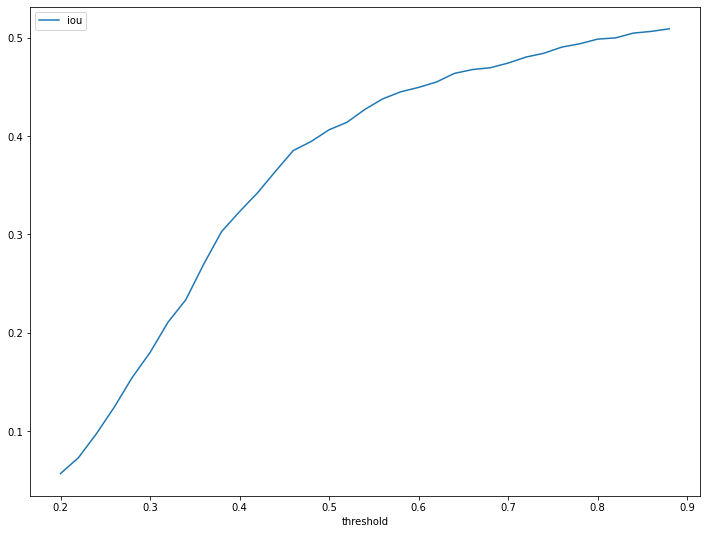

In [26]:
# 横:閾値　縦:IoU
df_iou.plot(x='threshold', y='iou')

## 前回使用した実装とはどのように違うのか

model

前回 : unet, 入力 : (conv, conv, MaxPool) 　→ダウンサンプリング : (conv, conv,   (drop), MaxPool )×3  　→中間層 : (conv, conv, drop)  　→アップサンプリング : (up, concat, conv, conv)×3　→出力 : (up, concat, conv, conv, conv, conv)


今回 : ResNet50, 入力～ダウンサンプリングまでResNet50, 　アップサンプリング～出力までオリジナルのU-Netモデル, エンコーダー : ResNet50 　デコーダー : decoder_block_simple((Conv + BatchNormalization + PReLu)) 　or　 decoder_block_bottleneck((Conv + BatchNormalization + PReLu + DropOut) ×3 + Add)(中間のフィルタサイズが半分)　　2つ組み合わせた : unet_resnet


評価関数

今回　: IoU

前回　: accuracy

## 転移学習をどのように行っているか

weights='imagenet' でkerasから学習済み重みの読み込んでいる。

## 【問題2】コードの書き換え
エンコーダーにResNetが使用されていたコードをVGGに変更してください。

In [28]:
base_model = VGG16(input_shape=input_size, include_top=False) 
base_model.summary()

58892288/58889256 [==============================] - 5s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [31]:
#U-Net, ResNetを組み合わせる
# エンコーダ　+ デコーダー
def unet_vgg(input_size, decoder_block,
                weights='imagenet',
                loss_func='binary_crossentropy',
                metrics_list=[my_iou_metric],
                use_lovash=False):

    # Base model - encoder
    # include_top=False : 全結合層含まない
    base_model = VGG16(
        input_shape=input_size, 
        include_top=False,
        weights=weights)
    
    # ResNet50のエンコーダ部分
    encoder1 = base_model.get_layer('block2_conv2').output
    encoder2 = base_model.get_layer('block3_conv3').output
    encoder3 = base_model.get_layer('block4_conv3').output
    encoder4 = base_model.get_layer('block5_conv3').output
    encoder5 = base_model.get_layer('block5_pool').output

    # 中間部分
    center = decoder_block(
        encoder5, 'center', num_filters=512)
    concat5 = concatenate([center, encoder5], axis=-1)

     # デコーダー部分。
     # すべてのデコーダーブロックは、エンコーダーとデコーダー部分からの連結出力を処理しました。
     # これによりスキップ接続が作成されます。
     # その後、デコーダー出力はエンコーダー出力部分に等しい次元にアップサンプリングされます。
    decoder4 = decoder_block(
        concat5, 'decoder4', num_filters=256)
    concat4 = concatenate([UpSampling2D()(decoder4), encoder4], axis=-1)

    decoder3 = decoder_block(
        concat4, 'decoder3', num_filters=128)
    concat3 = concatenate([UpSampling2D()(decoder3), encoder3], axis=-1)

    decoder2 = decoder_block(
        concat3, 'decoder2', num_filters=64)
    concat2 = concatenate([UpSampling2D()(decoder2), encoder2], axis=-1)

    decoder1 = decoder_block(
        concat2, 'decoder1', num_filters=64)
    concat1 = concatenate([UpSampling2D()(decoder1), encoder1], axis=-1)

    # Final upsampling and decoder block for segmentation.
    output = UpSampling2D()(concat1)
    output = decoder_block(
        output, 'decoder_output', num_filters=32)
    output = Conv2D(
        1, (1, 1), activation=None, name='prediction')(output)
    if not use_lovash:
        output = Activation('sigmoid')(output)
        
    model = Model(base_model.input, output)
    model.compile(loss=loss_func, optimizer='adam', metrics=metrics_list)

    return model

In [32]:
input_size = (224, 224, 3)


K.clear_session()
model = unet_vgg(
    input_size, decoder_block_simple, weights='imagenet')
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
____________________________________________________________________________________________

In [33]:
K.clear_session()

# diceとBCE (binary_crossentropy)の場合はmy_iou_metric 使用,
# lovash_lossの場合は my_iou_metric2 使用
# for lovash loss is between -inf and +inf, not between 0 and 1, as for BCE and dice.
# lovash_loss使用の場合最後の層(sigmoid)削除
# use_lovash で削除?
model_depth = unet_vgg(
    input_size, decoder_block_bottleneck, weights='imagenet',
    loss_func=bce_dice_loss, metrics_list=[my_iou_metric],
    use_lovash=False)

# ベストepoch回数の結果を保存(コールバックの一つ)
model_checkpoint = ModelCheckpoint(
    'unet_vgg.h5' ,monitor='val_my_iou_metric', mode='max',
    save_best_only=True, save_weights_only=True, verbose=1)
# 評価値が改善されないとき学習率下げる
reduce_lr = ReduceLROnPlateau(
    monitor='val_my_iou_metric',
    mode='max',
    factor=0.5, 
    patience=5, 
    min_lr=0.0001, 
    verbose=1)


epochs = 2  # 25
batch_size = 16

history = model_depth.fit(X_tr, y_tr,
                    validation_data=[X_val, y_val], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[model_checkpoint,reduce_lr], 
                    verbose=1)

Train on 3200 samples, validate on 800 samples
Epoch 1/2
3200/3200 [==============================] - 236s 74ms/step - loss: 0.9014 - my_iou_metric: 0.1469 - val_loss: 1.5268 - val_my_iou_metric: 0.1517

Epoch 00001: val_my_iou_metric improved from -inf to 0.15175, saving model to unet_vgg.h5
Epoch 2/2
3200/3200 [==============================] - 225s 70ms/step - loss: 0.7257 - my_iou_metric: 0.2227 - val_loss: 1.4029 - val_my_iou_metric: 0.1973

Epoch 00002: val_my_iou_metric improved from 0.15175 to 0.19725, saving model to unet_vgg.h5


In [34]:
val_preds = model_depth.predict(X_val, batch_size=16)

y_val_pred = np.asarray(list(map(lambda x: cv2.resize(x, (101, 101)), val_preds)))
y_val_true = np.asarray(list(map(lambda x: cv2.resize(x, (101, 101)), y_val)))

In [35]:
# src: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2
    
    # 2次元ヒストグラム作成
    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

In [36]:
# 閾値
thresholds = np.arange(0.2, 0.9, 0.02)

# 閾値ごとにIoU求める
ious = np.array(
    [iou_metric_batch(y_val_true,
                      np.int32(y_val_pred > threshold)) for threshold in tqdm(thresholds)])

100%|██████████| 35/35 [00:48<00:00,  1.39s/it]


In [37]:
df_iou = pd.DataFrame(thresholds, columns=['threshold'])
df_iou['iou'] = ious
# bestのIoUの時の閾値出力
best_index = df_iou['iou'].idxmax()
print('Best IoU: {:.4f} at threshold: {:.3f}'.format(
    df_iou.iou[best_index], df_iou.threshold[best_index]))

# Describe IoU DF
df_iou.describe()

Best IoU: 0.2776 at threshold: 0.380


,threshold,iou
count,35.000000,35.000000
mean,0.540000,0.263950
std,0.204939,0.007307
min,0.200000,0.251000
25%,0.370000,0.259125
50%,0.540000,0.263875
75%,0.710000,0.269937
max,0.880000,0.277625


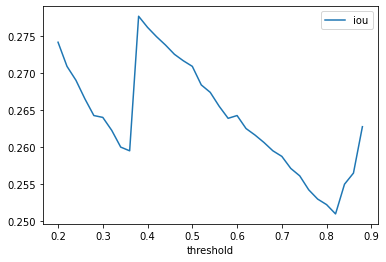

In [38]:
# 横:閾値　縦:IoU
df_iou.plot(x='threshold', y='iou')

## 【問題3】学習・推定
ResNetとVGG双方のコードで学習・推定を行い、結果を比較してください。

ResNetの方がIoUが高い